# Machine Learning For Lithography
## Unit II : Linear Classifiers

### Introduction

The Convolutional Neural Network (CNN) is a class of neural networks that are able to be trained efficiently for many problems, through exploitation of sparse connectivity between the neurons.  They are particularly useful for many communication problems where there is some justification for a strong prior that data can be organized in a list or matrix such that data outside of a local neighborhood can be assumed to be associated with zero weight.

A CNN architecture is attractive for a photoresist model because we have strong prior beliefs that the most important information about the photoresist contour position can be found near the rising and falling edges of the aerial image signal., and that the importance of the aerial image signal with regard to a specific contour point position diminishes with distance.

### Preamble

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from classes.Visualizations import *
from classes.Data import  loadResNIST, loadResNIST_balanced
from classes.Specs import specs
import logging


In [2]:
DATADIR='./resNIST'
LOGDIR = './linear_classifier_logs/'
PROJECTORDIR=LOGDIR+'projector/'
summary_writer = tf.summary.FileWriter(LOGDIR)
image_size=48
scopes = ['linear/linear_model/linear_model/weighted_sum:0','linear/head/labels:0']

### Load and Transform Data

In [3]:
train_data, train_labels , eval_data, eval_labels    = loadResNIST(DATADIR, image_size)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=256,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
feature_columns=[tf.feature_column.numeric_column("x",shape=[image_size,image_size])]

### Define the Estimator


In [8]:
config=tf.estimator.RunConfig(save_checkpoints_steps=1000)

linear_classifier = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    config=config,
    n_classes=11,
    optimizer=tf.train.FtrlOptimizer(learning_rate=0.1,
                                    l1_regularization_strength=0.02,
                                    l2_shrinkage_regularization_strength=0.02),
#    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
    model_dir=LOGDIR
)

INFO:tensorflow:Using config: {'_model_dir': './linear_classifier_logs/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001BFDB150358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [9]:

logging.getLogger().setLevel(logging.INFO)  
# to show info about training progress in the terminal
train_spec, eval_spec = specs(train_input_fn, eval_input_fn, 
                              logdir=LOGDIR, projectordir=PROJECTORDIR, 
                              max_train_steps=500000, eval_steps = 1000, 
                              scopes = scopes, name = 'lc')

In [10]:
tf.estimator.train_and_evaluate(linear_classifier, train_spec, eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 1000 or save_checkpoints_secs None.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./linear_classifier_logs/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30000 into ./linear_classifier_logs/model.ckpt.
INFO:tensorflow:loss = 160.92178, step = 30000
INFO:tensorflow:global_step/sec: 94.26
INFO:tensorflow:loss = 7.2535653, step = 30100 (1.041 sec)
INFO:tensorflow:global_step/sec: 84.8435
INFO:tensorflow:loss = 16.971704, step = 30200 (1.161 sec)
IN

hook end
11
Cumulative explained variation for 10 principal components: 0.9998970420740442 layer 0
INFO:tensorflow:Finished evaluation at 2019-02-14-19:20:47
INFO:tensorflow:Saving dict for global step 34000: accuracy = 0.85044754, average_loss = 0.6420135, global_step = 34000, loss = 82.13255
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 34000: ./linear_classifier_logs/model.ckpt-34000
INFO:tensorflow:global_step/sec: 16.3896
INFO:tensorflow:loss = 23.270575, step = 34000 (6.102 sec)
INFO:tensorflow:global_step/sec: 84.5895
INFO:tensorflow:loss = 83.413895, step = 34100 (1.181 sec)
INFO:tensorflow:global_step/sec: 83.7371
INFO:tensorflow:loss = 32.557228, step = 34200 (1.195 sec)
INFO:tensorflow:global_step/sec: 81.2142
INFO:tensorflow:loss = 69.561195, step = 34300 (1.255 sec)
INFO:tensorflow:global_step/sec: 79.5937
INFO:tensorflow:loss = 6.4391184, step = 34400 (1.233 sec)
INFO:tensorflow:global_step/sec: 83.3871
INFO:tensorflow:loss = 11.107046, step = 34500 (1.

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 38000: ./linear_classifier_logs/model.ckpt-38000
INFO:tensorflow:global_step/sec: 13.5803
INFO:tensorflow:loss = 10.916887, step = 38000 (7.341 sec)
INFO:tensorflow:global_step/sec: 87.7007
INFO:tensorflow:loss = 10.820303, step = 38100 (1.139 sec)
INFO:tensorflow:global_step/sec: 84.4981
INFO:tensorflow:loss = 53.02822, step = 38200 (1.183 sec)
INFO:tensorflow:global_step/sec: 85.8335
INFO:tensorflow:loss = 28.347902, step = 38300 (1.166 sec)
INFO:tensorflow:global_step/sec: 88.3228
INFO:tensorflow:loss = 26.881622, step = 38400 (1.158 sec)
INFO:tensorflow:global_step/sec: 81.9954
INFO:tensorflow:loss = 65.74065, step = 38500 (1.214 sec)
INFO:tensorflow:global_step/sec: 86.0736
INFO:tensorflow:loss = 32.51219, step = 38600 (1.142 sec)
INFO:tensorflow:global_step/sec: 42.4212
INFO:tensorflow:loss = 2.4526627, step = 38700 (2.359 sec)
INFO:tensorflow:global_step/sec: 78.7827
INFO:tensorflow:loss = 36.611347, step = 38800 (

INFO:tensorflow:global_step/sec: 82.4933
INFO:tensorflow:loss = 59.735714, step = 42200 (1.213 sec)
INFO:tensorflow:global_step/sec: 83.8065
INFO:tensorflow:loss = 44.713814, step = 42300 (1.193 sec)
INFO:tensorflow:global_step/sec: 85.8552
INFO:tensorflow:loss = 55.92271, step = 42400 (1.187 sec)
INFO:tensorflow:global_step/sec: 85.2386
INFO:tensorflow:loss = 120.459465, step = 42500 (1.150 sec)
INFO:tensorflow:global_step/sec: 70.5849
INFO:tensorflow:loss = 26.324835, step = 42600 (1.420 sec)
INFO:tensorflow:global_step/sec: 77.9737
INFO:tensorflow:loss = 139.18231, step = 42700 (1.280 sec)
INFO:tensorflow:global_step/sec: 86.754
INFO:tensorflow:loss = 76.35651, step = 42800 (1.152 sec)
INFO:tensorflow:global_step/sec: 80.4408
INFO:tensorflow:loss = 16.682598, step = 42900 (1.246 sec)
INFO:tensorflow:Saving checkpoints for 43000 into ./linear_classifier_logs/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 201

INFO:tensorflow:global_step/sec: 83.213
INFO:tensorflow:loss = 51.912525, step = 46500 (1.202 sec)
INFO:tensorflow:global_step/sec: 89.1918
INFO:tensorflow:loss = 48.883556, step = 46600 (1.121 sec)
INFO:tensorflow:global_step/sec: 88.3104
INFO:tensorflow:loss = 4.3053684, step = 46700 (1.133 sec)
INFO:tensorflow:global_step/sec: 87.7299
INFO:tensorflow:loss = 7.6036415, step = 46800 (1.140 sec)
INFO:tensorflow:global_step/sec: 83.4688
INFO:tensorflow:loss = 5.420458, step = 46900 (1.197 sec)
INFO:tensorflow:Saving checkpoints for 47000 into ./linear_classifier_logs/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-14-19:25:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./linear_classifier_logs/model.ckpt-47000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INF

KeyboardInterrupt: 

In [ ]:

accuracy_score = linear_classifier.evaluate(input_fn=eval_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

.\metadata.tsv


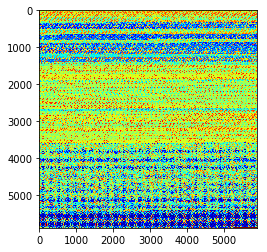

In [11]:
prepare_projector(PROJECTORDIR, scopes)
prepare_sprites(PROJECTORDIR, eval_data)

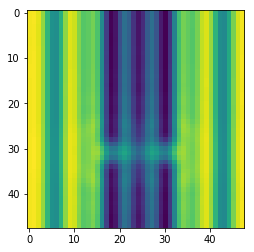

In [13]:
plt.imshow(eval_data[41170])

In [15]:
eval_labels[41170]

10

In [3]:
plt.imshow(training_data[3])

NameError: name 'training_data' is not defined